Created by Martin Knudsen (martin.knudsen(at)tum.de), July 2019.

NOTE: This notebooks has to be run consecutively, because the same variable names are often used. 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as snb
snb.set()
from sympy import integrate, Symbol, cos, exp, lambdify, sqrt
from scipy.linalg import circulant, expm
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
import copy

We aim to solve the following 1D Vlasov-Poisson system for electrons, 

$$\frac{∂f}{∂t}+v\frac{∂f}{∂x}−E\frac{∂f}{∂v}= 0,$$ 

$$−\frac{∂^2 φ}{∂x^2}= 1−∫f dv , \quad  E=−\frac{∂φ}{∂x}.$$

Here,$f >0$ is a function of $t∈[0,T]$, $x∈[0,L_x ]$ and $v∈[v_{min},v_{max}]$, $v_{min}<0<v_{max}$, assumed $L_x$-periodic and($v_{max}−v_{min}$)-periodic, respectively, and $φ=φ(t,x)$ is $L_x$-periodic


1. Using a point-based (FD or Fourier) Poisson solver, implement a solver for (1) via the Lir-Trotter splitting method for the Vlasov equation, i.e.  at each time step solvesequentially the two problems (A) and (B), for $t∈[t_n,tn+1]$,

$$(A) : \frac{∂f^∗ }{∂t}−E\frac{∂f^∗ }{∂v}= 0,\quad (B) :\frac{∂f}{∂t}+v\frac{∂f}{∂x}= 0,$$ 

$$f^∗ (t_n) =f(t_n), \quad f(t_n) =f^∗ (t_{n+1}).$$

Use a Fourier method for the space/velocity discretization in these constant-coefficientadvection problems and solve exactly (analytically) in time.

To solve the equations time dependendence analytically we just use seperation of variables 

$$(A) : \frac{∂f^∗ }{∂t}= E\frac{∂f^∗ }{∂v},\quad (B) :\frac{∂f}{∂t}= -v\frac{∂f}{∂x},$$ 


Define the system matrix and solve the poisson equation to get the phi for the energy

In [3]:
def systemMatrix(N, a, b):
    h=(b-a)/N
    A = np.eye(N)*2
    for i in range(N-1):
        A[i,i+1]=-1
        A[i+1,i]=-1
    A *= 1/h**2
    return A

In [4]:
def periodicSolver0Boundary(a, b, N, rightSide):
    h = (b-a)/N
    # the systme matrix is the old one
    A = systemMatrix(N=N, a=a, b=b)
    xlist = [a+i*h for i in range(1,N)]
    # the right hand side is just the rho at the grid points WITHOUT adding anything, because the
    # because the boundry points are 0 
    x = np.linalg.solve(A,rightSide)
    return x

In [48]:
def LieTrotterStepper(vList, xList, EList, ft, dt):
    '''
    Input:
        vList: discretization points in the v-direction
        xList: discretization points in the x-direction
        EList: 1D array of energies at the different grid points in the x-direction
        f: 2D array (Nx, Nv) containing the current values of f at the grid points at different x- and v-values
        dt: timestep
    Output:
        fb: 2D array containing the now updated f-values at the grid points
    '''
    
    # getting the wave numbers 
    nv = range(int(-Nv/2), int(Nv/2))
    kv = [2*np.pi/(vList[-1]-vList[0])*nvv for nvv in nv]
    
    nx = range(int(-Nx/2), int(Nx/2))
    kx = [2*nxx*np.pi/(xList[-1]) for nxx in nx]
    
    # use 2d fourier transform to go into fourier space
    # solve the A problem for dt
    # for each point the spatial derivative is just a 
    # multiplication, so it becomes just an exponential
    
    fv = np.fft.fft(ft,axis=1)
    vshift = np.array([np.exp(1j*EList[i]*kv[i]*dt) for i in range(Nv)])
    fv = vshift*np.fft.fftshift(fv,axes=(1,))
    # go back into physical space
    # the problem is that the coefficients are not conjugate symmetric, because N is even, so there is not the 
    # same number of coeffs on each side of the 0. But that's what we need because then the output is real. 
    # to make up for that fact we just take the real inverse transform from 0 to Nv/2
    ft = np.fft.irfft(np.fft.fftshift(fv, axes=(1,))[:,0:int(Nv/2+1)], axis=1)
    
    # solve the B problem for normal stepsize
    fx = np.fft.fft(ft,axis=0)
    xshift = np.array([np.exp(-1j*vList[j]*kx[j]*dt) for j in range(Nx)])
    fx = xshift*np.fft.fftshift(fx,axes=(0,))
    ft = np.fft.irfft(np.fft.fftshift(fx, axes=(0,))[0:int(Nx/2+1),:], axis=0)
    
    return ft

In Strang splitting we first solve (A) on a half time step,
then (B) on a full time step, then (A) on a half step again. 

In [8]:
def StrangStepper(vList, xList, EList, ft, dt):
    '''
    Input:
        vList: discretization points in the v-direction
        xList: discretization points in the x-direction
        EList: 1D array of energies at the different grid points in the x-direction
        f: 2D array (Nx, Nv) containing the current values of f at the grid points at different x- and v-values
        dt: timestep
    Output:
        fb: 2D array containing the now updated f-values at the grid points
    '''
    
    # getting the wave numbers 
    nv = range(int(-Nv/2), int(Nv/2))
    kv = [2*np.pi/(vList[-1]-vList[0])*nvv for nvv in nv]
    
    nx = range(int(-Nx/2), int(Nx/2))
    kx = [2*nxx*np.pi/(xList[-1]) for nxx in nx]
    
    # use 2d fourier transform to go into fourier space
    # solve the A problem for dt/2
    # for each point the spatial derivative is just a 
    # multiplication, so it becomes just an exponential
    
    fv = np.fft.fft(ft,axis=1)
    vshift = np.array([np.exp(1j*EList[i]*kv[i]*dt/2) for i in range(Nv)])
    fv = vshift*np.fft.fftshift(fv,axes=(1,))
     # go back into physical space
    ft = np.fft.irfft(np.fft.fftshift(fv, axes=(1,))[:,0:int(Nv/2+1)], axis=1)
    
    # solve the B problem for normal stepsize
    fx = np.fft.fft(ft,axis=0)
    xshift = np.array([np.exp(-1j*vList[j]*kx[j]*dt) for j in range(Nx)])
    fx = xshift*np.fft.fftshift(fx,axes=(0,))
    ft = np.fft.irfft(np.fft.fftshift(fx, axes=(0,))[0:int(Nx/2+1),:], axis=0)
    
    # solve A again on the half stepsize
    fv = np.fft.fft(ft,axis=1)
    vshift = np.array([np.exp(1j*EList[i]*kv[i]*dt/2) for i in range(Nv)])
    fv = vshift*np.fft.fftshift(fv,axes=(1,))
     # go back into physical space
    ft = np.fft.irfft(np.fft.fftshift(fv, axes=(1,))[:,0:int(Nv/2+1)], axis=1)
    
    return ft

Operation split solver that performs the iteration using the stepper and gathers all the data needed to check conservation.

In [52]:
def splitSolver(vList, xList, EList, T, dt, f0, method='lie-trotter'):
    '''
    Input:
        vList: discretization points in the v-direction
        xList: discretization points in the x-direction
        EList: 1D array of energies at the different grid points in the x-direction
        f: 2D array (Nx, Nv) containing the current values of f at 
        the grid points at different x- and v-values
        dt: timestep
    Output:
        fb: 3D array containing the now updated f-values
    '''
    
    # get stepsizes and number of domains from the points
    hx = xList[1]-xList[0] 
    hv = vList[1]-vList[0] 
    Nx = len(xList)
    Nv = len(vList)
    Lx = xList[-1]+hx
    
    # Save all the f-values at the grid in a 3D array.
    f = np.zeros((T+1, Nx, Nv))#, dtype='complex') 
    
    # arrays for holding the values of mass, momentum, energy, L2,
    # and field energy   
    mass = np.zeros(T+1)
    mass_rows = np.zeros(Nx)
    momentum = np.zeros(T+1)
    momentum_rows = np.zeros(Nx)
    plasma_energy_rows = np.zeros(Nx)
    total_energy = np.zeros(T+1)
    electric_rows = np.zeros(Nx)
    L2 = np.zeros(T+1)
    L2_rows = np.zeros(Nx)
    field_energy = np.zeros(T+1)    
    
    # for each timestep do
    for t in range(T+1):
        
        # fill out the initial values at the grid points
        if t==0:
            for i, x in enumerate(xList):
                for j, v in enumerate(vList):
                    f[0,i,j] = f0(x,v)
            #print(f[0])
        else:
            if method=='lie-trotter':
                f[t] = LieTrotterStepper(vList, xList, EList, f[t-1], dt)
            else:
                f[t] = StrangStepper(vList, xList, EList, f[t-1], dt)
        
        
        # All of the supposedly conserved quantities are calculated
        # by performing numerical double-integrals. 
        # first perform numerical integration in the v-direction
        for i in range(Nx):
            mass_rows[i] = np.trapz( f[t,i,:], vList )
            momentum_rows[i] = np.trapz( f[t,i,:]*vList, vList )
            plasma_energy_rows[i] = np.trapz( f[t,i,:]*np.power(vList,2), vList )
            electric_rows[i] = np.trapz( f[t,i,:], vList )
            L2_rows[i] = np.trapz( f[t,i,:]*f[t,i,:], vList )
        
        # then perform integration in the x-direction
        mass[t] = np.trapz( mass_rows, xList )
        momentum[t] = np.trapz( momentum_rows, xList )
        L2[t] = np.sqrt(np.trapz( L2_rows, xList ))
        
        # get the phi by solving the poisson equation with 
        # a periodic finite difference solver
        rightSide = 1-electric_rows
        phi = periodicSolver0Boundary(0, Lx, Nx, rightSide)
        # the energy is now the negative gradient
        EList = -np.gradient(phi)
        
        
        # the field energy is now the integral over the squared
        # energy
        field_energy[t] = np.trapz(EList**2/2, xList)
        
        plasma_energy = np.trapz(plasma_energy_rows, xList)/2
        
        total_energy[t] = plasma_energy + field_energy[t]
    
    # for the plotting we need dimensions like (T, Nv, Nx) so we
    # change the two dimensions. 
    fT = np.transpose(f, (0,2,1))
    
    return fT, mass, momentum, total_energy, L2, field_energy

2. Solve system (1) for $T= 30, L_x = 12, v_{max}=−v_{min}= 5$ and the initial condition 

$$f(0,x,v) =f_0 (x,v) = [1 + 0.01 cos(2πx/L_x )]\frac{1}{(2π)^{1/2}}e^{−v^2 /2}.$$ 

Choose an appropriate time step. Check for conservation of total mass, momentum, total energy and $L^2$-norm. Make a video of the evolution of $f$ in the $(x,v)$ - plane. Plot the field energy $∫|E|^2 /2dx$ as a function of time. Does your result change when changing phase space resolution (more grid points)? Implement also the Strang splitting method for the Vlasov equation and check whether your numerical results change. 

We have for the relation between the temporal and spatial stepsizes: 

$$\frac{\tau}{h^2}\leq \frac{1}{2}$$


but since the temporal step is analytical we do not need to use this. 

I use sympy to do the analytical integration

In [71]:
# constants 
Lx = 12
vmax = 5
vmin = -5
T = 30
dt = 0.01
Nx = 50
Nv = 50

# get the stepsizes and make the grid points
hx = Lx/Nx
hv = (vmax-vmin)/Nv
xList = [i*hx for i in range(Nx)]
vList = [vmin+i*hv for i in range(Nv)]

# use Sympy to get the analytical energy at the gridpoints
x = Symbol('x')
v = Symbol('v')
# The initial function as an expression in Sympy
f0 = (1+0.01*cos(2*np.pi*x/12))*1/(2*np.pi)**0.5*exp(-v**2/2)
# use Sympy to analytically double integrate the initial
integral_v = integrate(f0, v)
integral_limits = integral_v.subs(v, vmax)-integral_v.subs(v, vmin)

# transform the electric to a lambda function and then evaluate
# on the grid points
rho = lambdify(x, integral_limits)
EList = np.zeros(Nx)

# get the phi by solving the poisson equation with 
# a periodic finite difference solver
rightSide =  [1-rho(x) for x in xList]
phi = periodicSolver0Boundary(0, Lx, Nx, rightSide)
# the energy is now the negative gradient
EList = -np.gradient(phi)

# make the initial f-values into a lambda function for evaluation
f0Fun = lambdify((x,v), f0)

# solve the system using the solver for the Lie-Trotter and the 
# Strang method
f_lie, mass_lie, momentum_lie, energy_lie, L2_lie, field_energy_lie = \
splitSolver(vList, xList, EList=EList, T=T, dt=dt, f0=f0Fun)
f_strang, mass_strang, momentum_strang, energy_strang, L2_strang, field_energy_strang = \
splitSolver(vList, xList, EList=EList, T=T, dt=dt, f0=f0Fun, method='strang')

Lets  plot all of the conservation stuff for the Lie-Trotter and the Strang method

<IPython.core.display.Javascript object>


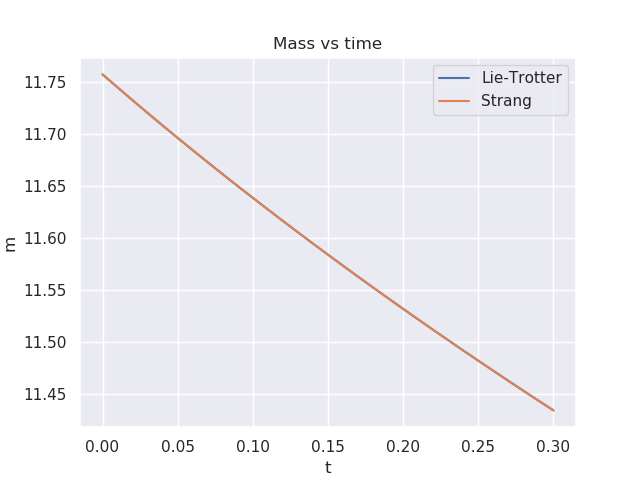

<IPython.core.display.Javascript object>


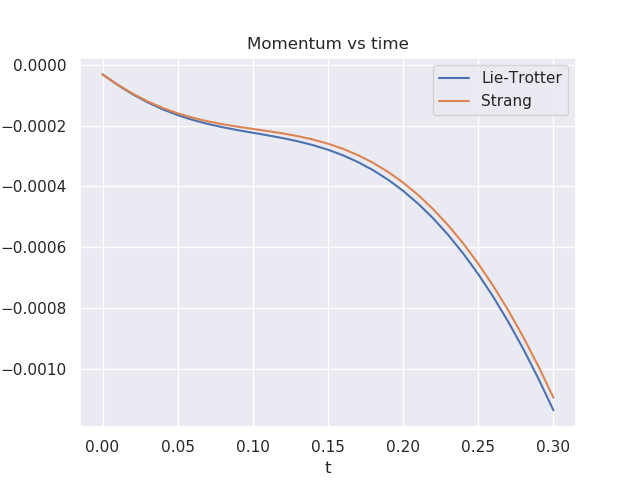

<IPython.core.display.Javascript object>


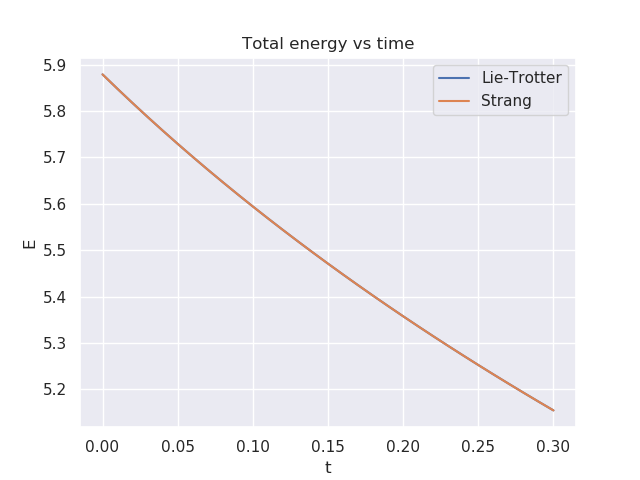

<IPython.core.display.Javascript object>


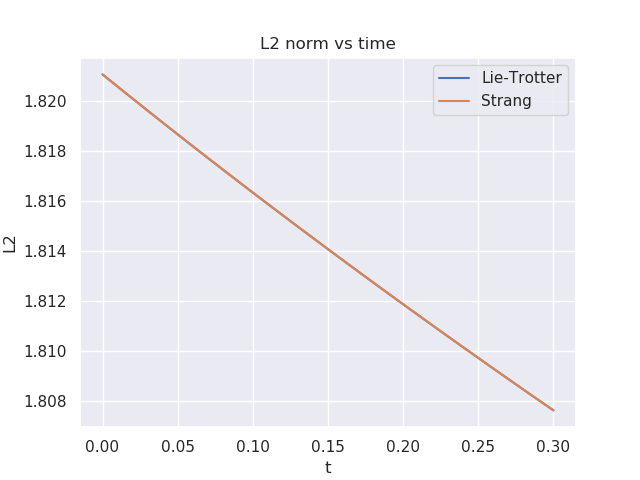

<IPython.core.display.Javascript object>


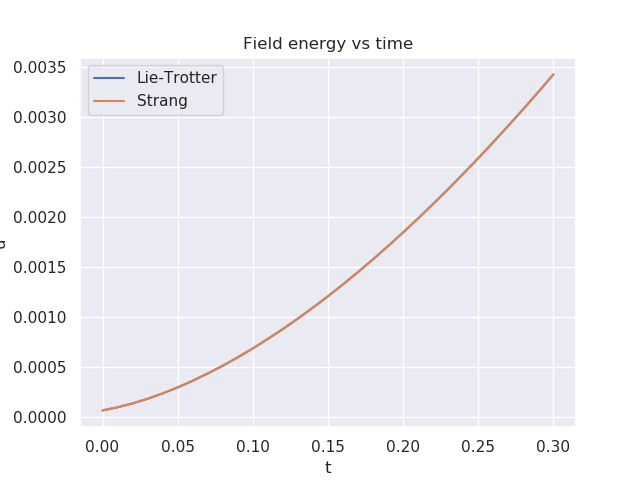

In [82]:
tList = [t*dt for t in range(T+1)]
plt.figure()
plt.plot(tList, mass_lie)
plt.plot(tList, mass_strang)
plt.legend(['Lie-Trotter', 'Strang'])
plt.xlabel('t')
plt.ylabel('m')
plt.title('Mass vs time')
plt.legend(['Lie-Trotter', 'Strang'])
plt.figure()
plt.plot(tList, momentum_lie)
plt.plot(tList, momentum_strang)
plt.xlabel('t')
plt.ylabel('p')
plt.title('Momentum vs time')
plt.legend(['Lie-Trotter', 'Strang'])
plt.figure()
plt.plot(tList, energy_lie)
plt.plot(tList, energy_strang)
plt.xlabel('t')
plt.ylabel('E')
plt.title('Total energy vs time')
plt.legend(['Lie-Trotter', 'Strang'])
plt.figure()
plt.plot(tList, L2_lie)
plt.plot(tList, L2_strang)
plt.xlabel('t')
plt.ylabel('L2')
plt.title('L2 norm vs time')
plt.legend(['Lie-Trotter', 'Strang'])
plt.figure()
plt.plot(tList, field_energy_lie)
plt.plot(tList, field_energy_strang)
plt.xlabel('t')
plt.ylabel('u')
plt.title('Field energy vs time')
plt.legend(['Lie-Trotter', 'Strang'])

Animation is done using matplotlib.animations. In order to plot in the notebook it needs to be of type matplotlib

<IPython.core.display.Javascript object>


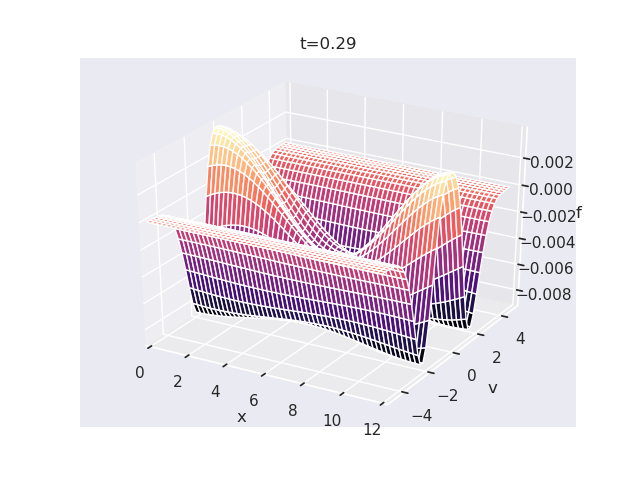

<IPython.core.display.Javascript object>


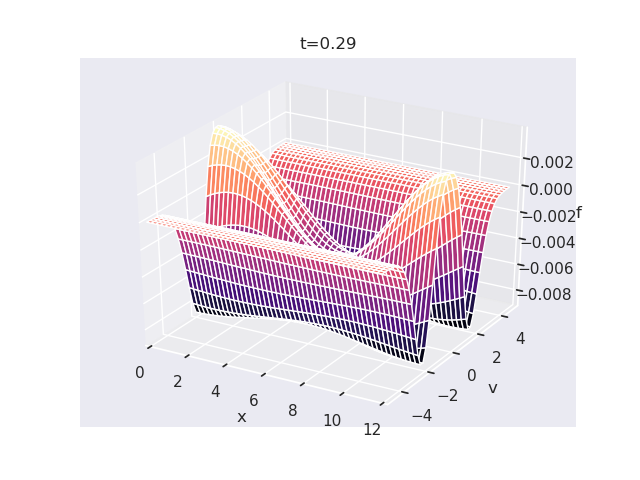

In [92]:
# without this no animation
%matplotlib notebook

# using meshgrid to make gridpoints
X, V = np.meshgrid(xList, vList)


x = Symbol('x')
v = Symbol('v')
# here we subtract the equilibrium contribution
feq = 1/(2*np.pi)**0.5*exp(-v**2/2)
feqLambda = lambdify((v, x), feq)
feqVal = np.ones((Nv, Nx))
for i, x in enumerate(xList):
    for j, v in enumerate(vList):
        feqVal[j,i] = feqLambda(v,x)  


# animation stuff. The update plot function is run at every frame
Writer = animation.writers['ffmpeg']
writer = Writer(fps=20, metadata=dict(artist='Me'), bitrate=1800)
def update_plot(frame_number, zarray, plot, dt, ax):
    plot[0].remove()
    plot[0] = ax.plot_surface(X, V, zarray[frame_number]-feqVal, cmap="magma")
    ax.set_title('t='+str(round(dt*frame_number,4)))

# plot the first frame of the figure for Lie-Trootter
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('v')
ax.set_zlabel('f')
ax.set_xlim([0, Lx])
ax.set_ylim([vmin, vmax])
plot = [ax.plot_surface(X, V, f_lie[0]-feqVal, color='0.75', rstride=1, cstride=1)]
# run it's animation
ani = animation.FuncAnimation(fig, update_plot, 30, fargs=(f_lie, plot, dt, ax), interval=1000, repeat=False)

# plot and animate the second figure for Strang
fig = plt.figure()
ax2 = fig.add_subplot(111, projection='3d')
ax2.set_xlabel('x')
ax2.set_ylabel('v')
ax2.set_zlabel('f')
ax2.set_xlim([0, Lx])
ax2.set_ylim([vmin, vmax])
plot = [ax2.plot_surface(X, V, f_strang[0]-feqVal, color='0.75', rstride=1, cstride=1)]
cc = animation.FuncAnimation(fig, update_plot, T, fargs=(f_strang, plot, dt, ax2), interval=1000, repeat=False)


3. Two-stream instability: set the velocity domain to $v∈[−10,10]$ and run your VP-solver with the initial condition

$$f(0,x,v) =\frac{1}{2}[\frac{1}{√2π}e^{−(v−v_0 )^2 /2}+\frac{1}{√2π}e^{−(v+v_0 )^2 /2}](1 + 10^{−3} cos(k x)),\quad  k= 0.2,$$ 

and with $L_x= 2π/k, T= 50, N_x=N_v= 256$. For the different stream velocities $v_0$ given below, plot the square root of the field energy $∫|E|^2 dx$ as a function of time and compare to the analytic growth $e^{ω_i t}$, obtained from the dispersion relation: 

$$v_0= 1.3 (ω_i = 0.0011),\quad  v_0= 2.4 (ω_i = 0.2258),\quad  v_0 = 3.0 (ω_i = 0.2845).$$


The solution is the same as before, except with different starting values

In [102]:
# constants
Nx = 256
Nv = 256
k = 0.2
Lx = 2*np.pi/k
vmax = 10
vmin = -10
T = 50
dt = 0.001

# get the stepsizes and make the grid points
hx = Lx/Nx
hv = (vmax-vmin)/Nv
xList = [i*hx for i in range(Nx)]
vList = [vmin+i*hv for i in range(Nv)]

# use Sympy to get the analytical energy at the gridpoints
x = Symbol('x')
v = Symbol('v')
vo = Symbol('vo')
f0 = 1/2*(1/sqrt(2*np.pi)*exp(-(v-vo)**2/2)+
                          1/sqrt(2*np.pi)* exp(-(v+vo)**2/2))*(1+10**(-3)*cos(0.2*x))

# use Sympy to analytically integrate the initial value over v
integral_v = integrate(f0, v)
         
# arrays to hold all the data for the different v0's
f = np.zeros((3, T+1, Nv, Nx))
mass = np.zeros((3, T+1))
momentum = np.zeros((3, T+1))
energy = np.zeros((3, T+1))
L2 = np.zeros((3, T+1))
field_energy = np.zeros((3, T+1))

# different values from the dispersion relations
wiList = [0.0011, 0.2258, 0.2845]
v0List = [1.3, 2.4, 3.0]

for k, v0 in enumerate(v0List):
    # Substitute the current v0 into the initial expression
    f0v0 = f0.subs(vo, v0)
    
    # use Sympy to analytically integrate the initial value over v
    integral_v = integrate(f0v0, v)
    integral_limits = integral_v.subs(v, vmax)-integral_v.subs(v, vmin)
    
    # transform the electric to a lambda function and then evaluate
    # on the grid points
    rho = lambdify(x, integral_limits)
    EList = np.zeros(Nx)

    # get the phi by solving the poisson equation with 
    # a periodic finite difference solver
    rightSide =  [1-rho(x) for x in xList]
    phi = periodicSolver0Boundary(0, Lx, Nx, rightSide)
    # the electric field is now the negative gradient
    EList = -np.gradient(phi)
    
    # make initial expression to a lambda function
    fFun = lambdify((x,v), f0v0)
    
    # solve system using Lie-Trotter
    f[k], mass[k], momentum[k], energy[k], L2[k], field_energy[k] = splitSolver(vList, xList, EList=EList, T=T, dt=dt, f0=fFun, method='strang')

Plot the square root of the field energy as a function os time for each inital v0 value. It looks quite weird,
there is an error here. 

<IPython.core.display.Javascript object>


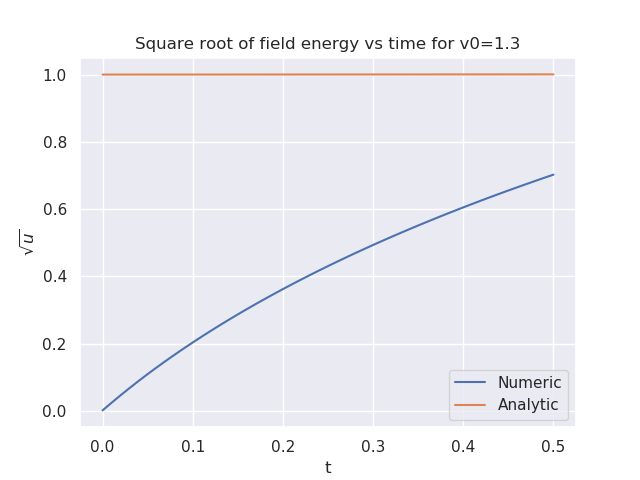

<IPython.core.display.Javascript object>


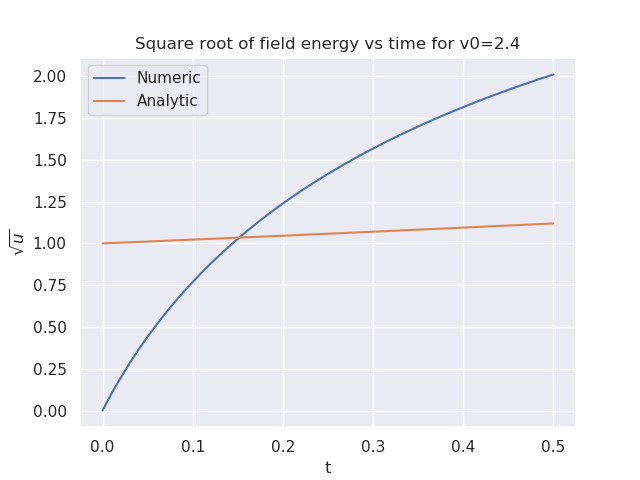

<IPython.core.display.Javascript object>


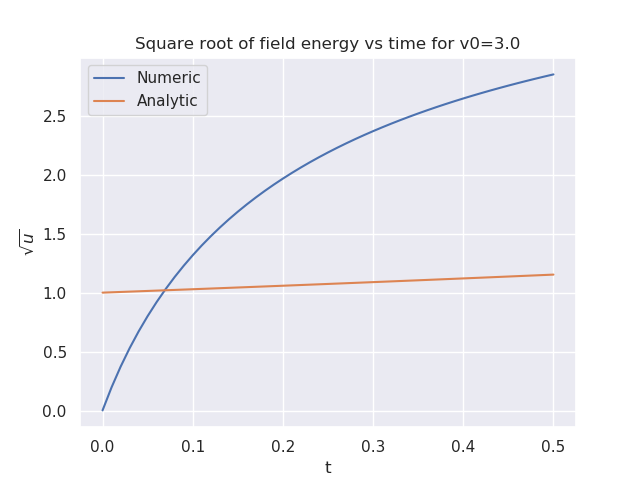

In [96]:
tList = [t*dt for t in range(T+1)]
for i, v0 in enumerate(v0List):
    # the analytical solution
    ana = [np.exp(wiList[i]*t) for t in tList]
    # sqrt of the field energy
    num = np.sqrt(field_energy[i])
    plt.figure()
    plt.plot(tList, num)
    plt.plot(tList, ana)
    plt.xlabel('t')
    plt.ylabel('$\sqrt{u}$')
    plt.title('Square root of field energy vs time for v0='+str(v0))
    plt.legend(['Numeric','Analytic'])

Do the animation for all v0's for fun. It looks good in the beginning

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
[[7.31148179e-21 7.30927971e-21 7.30267479e-21 ... 7.29167101e-21
  7.30267479e-21 7.30927971e-21]
 [1.43834998e-20 1.43791678e-20 1.43661742e-20 ... 1.43445271e-20
  1.43661742e-20 1.43791678e-20]
 [2.81237363e-20 2.81152660e-20 2.80898601e-20 ... 2.80475338e-20
  2.80898601e-20 2.81152660e-20]
 ...
 [5.46551059e-20 5.46386448e-20 5.45892715e-20 ... 5.45070155e-20
  5.45892715e-20 5.46386448e-20]
 [2.81237363e-20 2.81152660e-20 2.80898601e-20 ... 2.80475338e-20
  2.80898601e-20 2.81152660e-20]
 [1.43834998e-20 1.43791678e-20 1.43661742e-20 ... 1.43445271e-20
  1.43661742e-20 1.43791678e-20]]
[[ 6.20774573e-17  1.03710821e-16  4.81996694e-17 ...  4.81996694e-17
   7.59552451e-17  7.59552451e-17]
 [-1.67625686e-12 -1.67636788e-12 -1.67653442e-12 ... -1.67572951e-12
  -1.67589604e-12 -1.67609033e-12]
 [-3.81214541e-12 -3.81243685e-12 -3.81283930e-

<IPython.core.display.Javascript object>


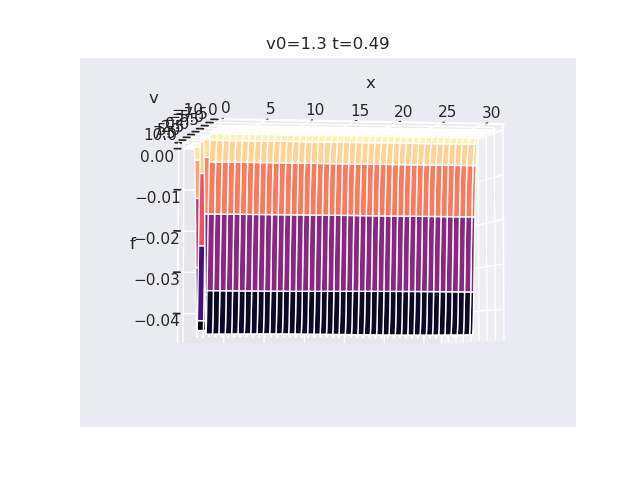

<IPython.core.display.Javascript object>


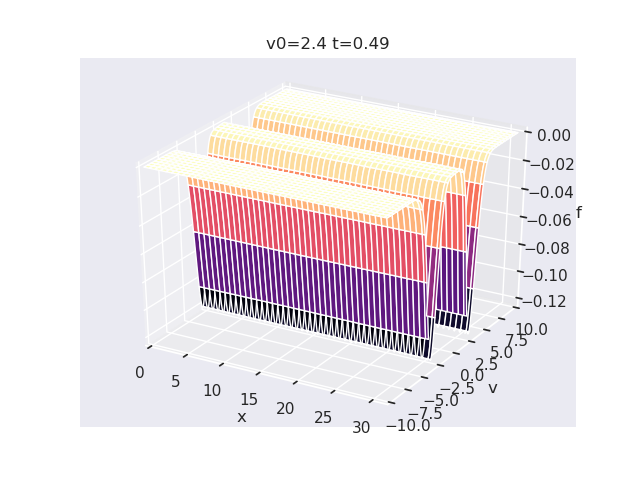

<IPython.core.display.Javascript object>


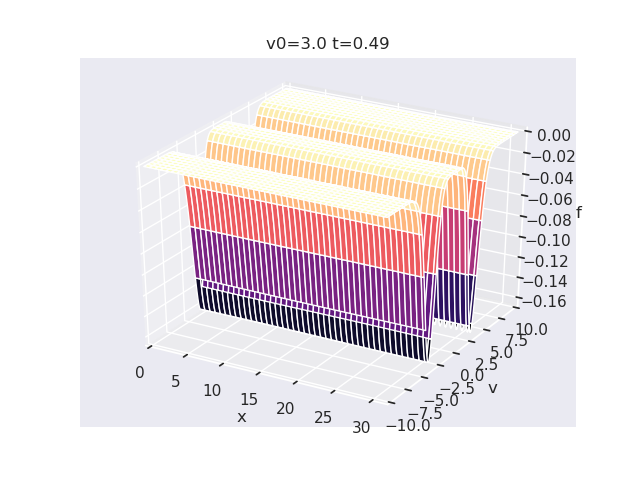

In [101]:
%matplotlib notebook

# using meshgrid to make gridpoints
X, V = np.meshgrid(xList, vList)

# all of this is to subtract the equilibrium solution 
x = Symbol('x')
v = Symbol('v')

feq1 = 1/2*(1/sqrt(2*np.pi)*exp(-(v-v0List[0])**2/2)+1/sqrt(2*np.pi)* exp(-(v+v0List[0])**2/2))
feq2 = 1/2*(1/sqrt(2*np.pi)*exp(-(v-v0List[1])**2/2)+1/sqrt(2*np.pi)* exp(-(v+v0List[1])**2/2))
feq3 = 1/2*(1/sqrt(2*np.pi)*exp(-(v-v0List[2])**2/2)+1/sqrt(2*np.pi)* exp(-(v+v0List[2])**2/2))

feqLambda1 = lambdify((v), feq1)
feqLambda2 = lambdify((v), feq2)
feqLambda3 = lambdify((v), feq3)

feqVal1 = np.ones((Nv, Nx))
feqVal2 = np.ones((Nv, Nx))
feqVal3 = np.ones((Nv, Nx))
for i, x in enumerate(xList):
    for j, v in enumerate(vList):
        feqVal1[j,i] = feqLambda1(v)
        feqVal2[j,i] = feqLambda2(v)
        feqVal3[j,i] = feqLambda3(v)        

feqPlot1 = np.ones((T+1, Nv, Nx))
feqPlot2 = np.ones((T+1, Nv, Nx))
feqPlot3 = np.ones((T+1, Nv, Nx))

for t in range(T+1):
    print(t)
    feqPlot1[t] = f[0,t]-feqVal1
    feqPlot2[t] = f[1,t]-feqVal2
    feqPlot3[t] = f[2,t]-feqVal3

print(feqPlot1[0])
print(feqPlot1[1])
# animation stuff. The update plot function is run at every frame
Writer = animation.writers['ffmpeg']
writer = Writer(fps=20, metadata=dict(artist='Me'), bitrate=1800)
def update_plot(frame_number, zarray, plot, dt, ax, version):
    plot[0].remove()
    plot[0] = ax.plot_surface(X, V, zarray[frame_number], cmap="magma")
    ax.set_title(version+' t='+str(round(dt*frame_number,4)))

# plot the first frame of the figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('v')
ax.set_zlabel('f')
ax.set_xlim([0, Lx])
ax.set_ylim([vmin, vmax])
plot = [ax.plot_surface(X, V, feqPlot1[0], color='0.75', rstride=1, cstride=1)]
# run it's animation
ani1 = animation.FuncAnimation(fig, update_plot, T, fargs=(feqPlot1, plot, dt, ax, 'v0=1.3'), interval=1000, repeat=False)

# plot and animate the second figure
fig = plt.figure()
ax2 = fig.add_subplot(111, projection='3d')
ax2.set_xlabel('x')
ax2.set_ylabel('v')
ax2.set_zlabel('f')
ax2.set_xlim([0, Lx])
ax2.set_ylim([vmin, vmax])

plot = [ax2.plot_surface(X, V, feqPlot2[0], color='0.75', rstride=1, cstride=1)]
ani2 = animation.FuncAnimation(fig, update_plot, T, fargs=(feqPlot2, plot, dt, ax2, 'v0=2.4'), interval=1000, repeat=False)

# third plot and animation
fig = plt.figure()
ax3 = fig.add_subplot(111, projection='3d')
ax3.set_xlabel('x')
ax3.set_ylabel('v')
ax3.set_zlabel('f')
ax3.set_xlim([0, Lx])
ax3.set_ylim([vmin, vmax])
plot = [ax3.plot_surface(X, V, feqPlot3[0], color='0.75', rstride=1, cstride=1)]
ani3 = animation.FuncAnimation(fig, update_plot, T, fargs=(feqPlot3, plot, dt, ax3, 'v0=3.0'), interval=1000, repeat=False)